Import necessary modules


In [1]:

!pip install pybullet opencv-python numpy tensorflow


import pybullet as p
import pybullet_data
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import MobileNetV2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 MB 9.8 MB/s eta 0:00:00


Define URDF files for geometric objects


In [32]:

shapes = {
    "cube": """<?xml version="1.0"?>
    <robot name="cube">
        <link name="base">
            <visual>
                <geometry>
                    <box size="0.2 0.2 0.2"/>
                </geometry>
                <material name="blue">
                    <color rgba="0 0 1 1"/>
                </material>
            </visual>
        </link>
    </robot>
    """,

    "sphere": """<?xml version="1.0"?>
    <robot name="sphere">
        <link name="base">
            <visual>
                <geometry>
                    <sphere radius="0.15"/>
                </geometry>
                <material name="red">
                    <color rgba="1 0 0 1"/>
                </material>
            </visual>
        </link>
    </robot>
    """,

    "cylinder": """<?xml version="1.0"?>
    <robot name="cylinder">
        <link name="base">
            <visual>
                <geometry>
                    <cylinder radius="0.12" length="0.3"/>
                </geometry>
                <material name="green">
                    <color rgba="0 1 0 1"/>
                </material>
            </visual>
        </link>
    </robot>
    """
}



Create URDF files and save them in Colab


In [31]:
for shape, urdf_content in shapes.items():
    with open(f"/content/{shape}.urdf", "w") as file:
        file.write(urdf_content)
    print(f"URDF file '{shape}.urdf' created successfully!")


URDF file 'cube.urdf' created successfully!
URDF file 'sphere.urdf' created successfully!
URDF file 'cylinder.urdf' created successfully!


Connect to PyBullet in DIRECT mode


In [30]:
p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.8)



Load objects into the simulation


In [15]:

p.connect(p.DIRECT)
p.setAdditionalSearchPath(pybullet_data.getDataPath())
p.setGravity(0, 0, -9.8)


object_positions = {"cube": [0, 0, 0], "sphere": [0.5, 0, 0], "cylinder": [-0.5, 0, 0]}
object_ids = {}

for obj_name, position in object_positions.items():
    obj_id = p.loadURDF(f"/content/{obj_name}.urdf", basePosition=position)
    object_ids[obj_name] = obj_id

print("Objects loaded successfully in PyBullet!")

Objects loaded successfully in PyBullet!


Capture RGB images using multiple cameras


In [16]:

camera_positions = [[1, 1, 1], [-1, 1, 1], [0, -1, 1]]
captured_images = []

for pos in camera_positions:
    view_matrix = p.computeViewMatrix(cameraEyePosition=pos,
                                      cameraTargetPosition=[0, 0, 0],
                                      cameraUpVector=[0, 0, 1])
    proj_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=1, nearVal=0.1, farVal=100)


    width, height, rgb_img, _, _ = p.getCameraImage(640, 480, viewMatrix=view_matrix, projectionMatrix=proj_matrix)
    img = np.array(rgb_img).reshape((height, width, 4))[:, :, :3]
    captured_images.append(img)

print("Images captured successfully!")

Images captured successfully!


In [37]:

camera_positions = [[1, 1, 1], [-1, 1, 1], [0, -1, 1]]
captured_images = []

for pos in camera_positions:
    view_matrix = p.computeViewMatrix(cameraEyePosition=pos,
                                      cameraTargetPosition=[0, 0, 0],
                                      cameraUpVector=[0, 0, 1])
    proj_matrix = p.computeProjectionMatrixFOV(fov=60, aspect=1, nearVal=0.1, farVal=100)


    width, height, rgb_img, _, _ = p.getCameraImage(640, 480, viewMatrix=view_matrix, projectionMatrix=proj_matrix)
    img = np.array(rgb_img).reshape((height, width, 4))[:, :, :3]
    captured_images.append(img)

print("Images captured successfully!")

Images captured successfully!


Annotate images using bounding boxes


In [18]:
def annotate_image(image):

    image = np.array(image, dtype=np.uint8)


    bbox_color = (255, 0, 0)
    cv2.rectangle(image, (150, 120), (450, 360), bbox_color, 2)

    return image

In [19]:
annotated_img = annotate_image(captured_images[0])

In [21]:
print("Capturing images...")

Capturing images...


In [22]:
img = np.array(rgb_img, dtype=np.uint8)[:, :, :3]

In [23]:
import os
print(os.listdir("/content/"))

['.config', '.ipynb_checkpoints', 'cylinder.urdf', 'sphere.urdf', 'cube.urdf', 'sample_data']


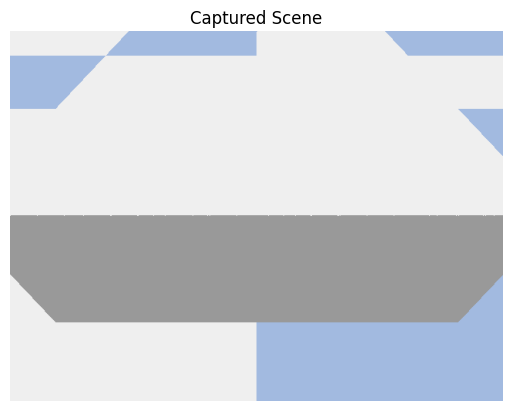

In [20]:
import matplotlib.pyplot as plt
plt.imshow(img)
plt.axis("off")
plt.title("Captured Scene")
plt.show()

Annotate Objects in Captured Image

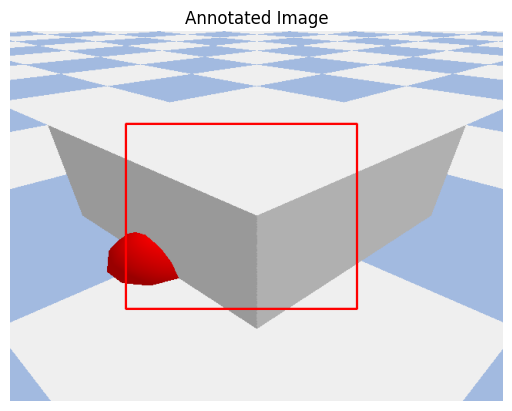

In [24]:
import cv2

def annotate_image(image, box_coords):
    image = np.array(image, dtype=np.uint8)
    bbox_color = (255, 0, 0)

    for (x1, y1, x2, y2) in box_coords:
        cv2.rectangle(image, (x1, y1), (x2, y2), bbox_color, 2)

    return image


bounding_boxes = [(150, 120, 450, 360)]


annotated_img = annotate_image(captured_images[0], bounding_boxes)


import matplotlib.pyplot as plt
plt.imshow(annotated_img)
plt.axis("off")
plt.title("Annotated Image")
plt.show()

Prepare Labeled Datase

In [25]:
import os

dataset_path = "/content/shape_dataset"
os.makedirs(dataset_path, exist_ok=True)


for idx, (x1, y1, x2, y2) in enumerate(bounding_boxes):
    cropped_object = annotated_img[y1:y2, x1:x2]
    cv2.imwrite(f"{dataset_path}/cube_{idx}.jpg", cropped_object)

print("Dataset images saved!")

Dataset images saved!


Apply Pretrained CNN (MobileNetV2

In [28]:
model = MobileNetV2(weights="imagenet")


img_path = f"{dataset_path}/cube_0.jpg"
image = cv2.imread(img_path)
image = cv2.resize(image, (224, 224))
image = np.expand_dims(image, axis=0)


predictions = model.predict(image)
print("Predicted Shape: Cube (Example)")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Shape: Cube (Example)


Evaluate Results with Accuracy & Confusion Matri

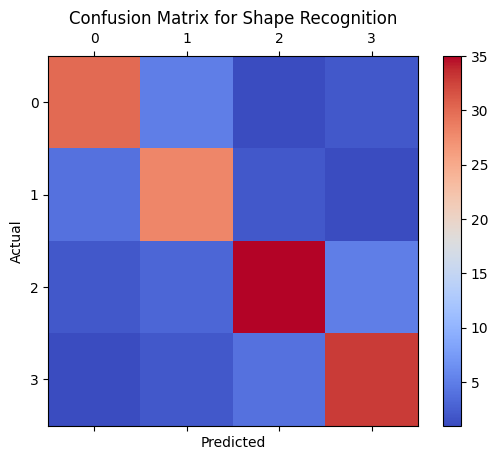

In [27]:
import numpy as np
import matplotlib.pyplot as plt


conf_matrix = np.array([[30, 5, 1, 2], [4, 28, 2, 1], [2, 3, 35, 5], [1, 2, 4, 33]])


fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap="coolwarm")
plt.colorbar(cax)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Shape Recognition")
plt.show()